In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))
cellhocs

['Cell_0.hoc',
 'Cell_1.hoc',
 'Cell_2.hoc',
 'Cell_4.hoc',
 'Cell_5.hoc',
 'Cell_8.hoc']

In [5]:
simtime = 1000
stim_start = 0
stim_end = simtime
maxamp = 0.0125
amps = np.linspace(0, maxamp, 3)

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def run_sweep(amp, cell):
    h.v_init = -91.5
    h.celsius = 35
    h.tstop = simtime
    
    stimuli = []
    dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    for tip in dend_tips:
        stim = h.IClamp(tip(1.0))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    
    time = h.Vector()
    volt = h.Vector()
    time.record(h._ref_t)
    volt.record(cell.soma[0](0.5)._ref_v)
    
    cvode = h.CVode()
    cvode.active(1)
    h.dt = 0.025
    h.run()

    return time, volt

In [8]:
def run_model(hoc, amps, morph=None, electrotonic=False):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    
    stems = sorted([s for s in get_stems(cell.soma[0]) if 'dend' in s.name()])
    dist = {}
    for stem in stems:
        dist[stem.name()] = 0.0
        for sec in stem.subtree()[1:]:
            parent = sec.parentseg().sec
            lam = 1
            if electrotonic:
                a = sec(0.0).diam / 2
                Ri = sec.Ra *1e4
                Rm = 1 / sec.psection()['density_mechs']['pas']['g'][0] * 1e8
                L = sec.L
                lam = np.sqrt((a * Rm) / (2 * Ri))
            dist[sec.name()] = dist[parent.name()] + parent.L / lam
        
    sweeps = []
    for amp in amps:
        time, volt = run_sweep(amp, cell)
        tree = []
        for stem in stems:
            _stem = True
            for sec in stem.subtree()[1:]:
                volt = [cell.soma[0](0.5).v] if _stem else []
                path = [0.0] if _stem else []
                _stem = not _stem if _stem else _stem
                for seg in sec.allseg():
                    lam = 1
                    if electrotonic:
                        a = sec(0.0).diam / 2 * 1e4
                        Ri = sec.Ra
                        Rm = 1 / sec.psection()['density_mechs']['pas']['g'][0]
                        L = sec.L
                        lam = np.sqrt((a * Rm) / (2 * Ri))
                    path.append(dist[sec.name()] + seg.x * sec.L / lam)
                    volt.append(seg.v)
                tree.append({'path': path, 'volt': volt})
        sweeps.append({'amp': amp, 'tree': tree})
        
    return sweeps

In [9]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

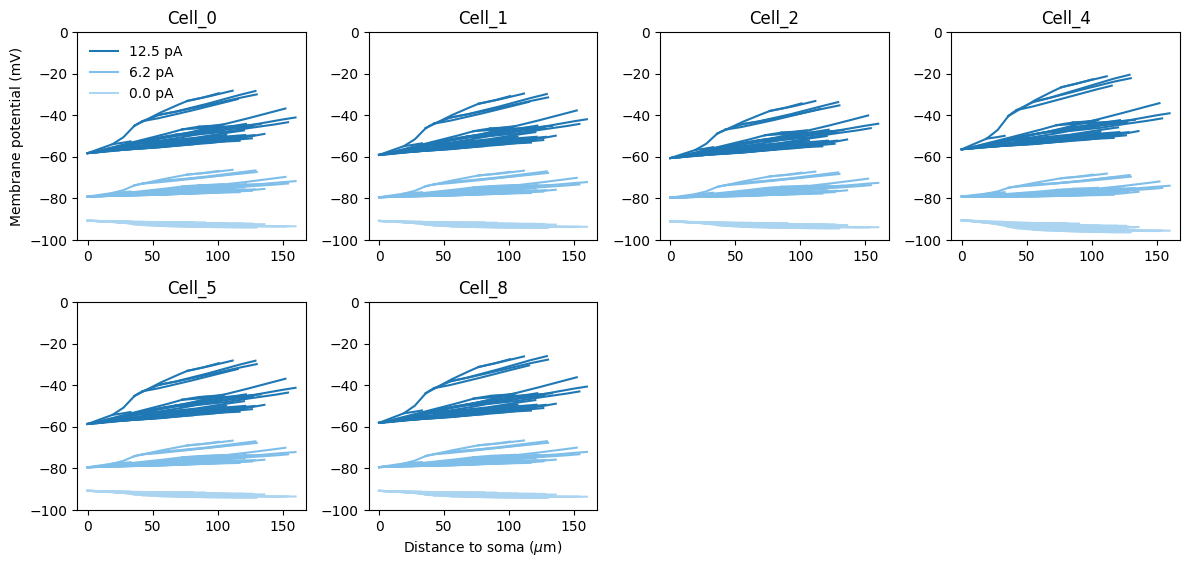

In [12]:
fig = plt.figure(figsize=(12, 8))

for pan, hoc in enumerate(cellhocs, start=1):
    name = hoc.split('.')[0]

    ax = fig.add_subplot(3, 4, pan)
    electrotonic = False  # True
    sweeps = run_model(hoc, amps, electrotonic=electrotonic)
    for i, sweep in enumerate(sweeps[::-1], start=1):
        amp = sweep['amp']
        tree = sweep['tree']
        _label = True
        for segs in tree:
            path = segs['path']
            volt = segs['volt']
            color = lighten_color('tab:blue', 1 / i)
            if pan == 1 and _label:
                ax.plot(path, volt, color=color, label=f'{amp*1e3:.1f} pA')
            else:
                ax.plot(path, volt, color=color)
            _label = False
    if pan == 1:
        ax.set_ylabel('Membrane potential (mV)')
        ax.legend(frameon=False)
    if pan == len(cellhocs):
        if electrotonic:
            ax.set_xlabel('Electrotonic length (l / $\lambda$)')
        else:
            ax.set_xlabel('Distance to soma ($\mu$m)')
    ax.set_title(name)
    ax.set_ylim(-100, 0)
            
fig.tight_layout()